# OCR Training on Real Data


**Dataset:** `sonnetechnology/license-plate-text-recognition-full`


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from datasets import load_dataset
import string

IMG_WIDTH = 200
IMG_HEIGHT = 50
BATCH_SIZE = 64
EPOCHS = 30
MAX_LENGTH = 10

CHARACTERS = string.digits + string.ascii_uppercase
print(f"Vocabulary size: {len(CHARACTERS)}")

Vocabulary size: 36


## 1. Load & Inspect Dataset

Loading dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'bbox', 'target'],
        num_rows: 6176
    })
    validation: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'bbox', 'target'],
        num_rows: 1765
    })
    test: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'bbox', 'target'],
        num_rows: 882
    })
})


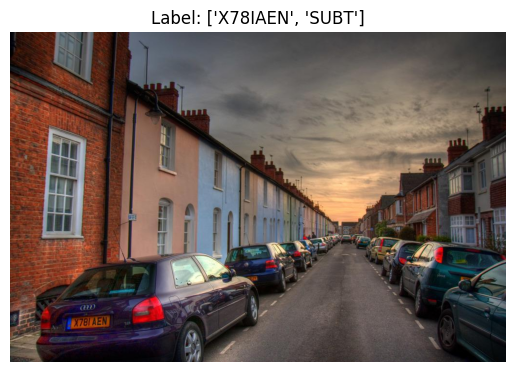

In [ ]:
print("Loading dataset...")
dataset = load_dataset("sonnetechnology/license-plate-text-recognition-full")

print(dataset)

sample = dataset['train'][0]
plt.imshow(sample['image'])
plt.title(f"Label: {sample['target']}") 
plt.axis('off')
plt.show()

## 2. Preocessing & Splitting

In [ ]:
import re

char_to_num = layers.StringLookup(
    vocabulary=list(CHARACTERS), mask_token=None, num_oov_indices=0
)
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, num_oov_indices=0, invert=True
)

def preprocess_sample_data(sample):
    img_pil = sample['image']
    
    bbox = sample.get('bbox', None)
    if bbox:
        if isinstance(bbox[0], list): 
            bbox = bbox[0]
            
        x1, y1, x2, y2 = bbox
        img_pil = img_pil.crop((x1, y1, x2, y2))
        
    img = img_pil.convert('L') 
    img = img.resize((IMG_WIDTH, IMG_HEIGHT))
    img = np.array(img).astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=-1)
    img = np.transpose(img, (1, 0, 2)) 
    
    label = sample['target']
    if isinstance(label, list):
        if len(label) > 0: 
            label = label[0]
        else: 
            label = ""
    
    label = str(label).upper()
    label = re.sub(r'[^A-Z0-9]', '', label)
        
    return img, label

class RealOCRDataset(tf.keras.utils.Sequence):
    def __init__(self, hf_dataset, batch_size=32):
        self.dataset = hf_dataset
        self.batch_size = batch_size
        self.indices = np.arange(len(self.dataset))

    def __len__(self):
        return int(np.ceil(len(self.dataset) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_images = []
        batch_labels = []
        
        for i in batch_indices:
            sample = self.dataset[int(i)]
            try:
                img, txt = preprocess_sample_data(sample)
                if txt == "":
                    continue
                batch_images.append(img)
                batch_labels.append(txt)
            except Exception as e:
                continue
        
        if not batch_images:
             nex_idx = (idx + 1) % self.__len__()
             return self.__getitem__(nex_idx)

        batch_images = np.array(batch_images)
        
        batch_labels_ragged = char_to_num(tf.strings.unicode_split(batch_labels, input_encoding="UTF-8"))
        batch_labels_tensor = batch_labels_ragged.to_tensor(default_value=-1, shape=[len(batch_labels), MAX_LENGTH])

        return {"image": batch_images, "label": batch_labels_tensor}
    
    def on_epoch_end(self):
        np.random.shuffle(self.indices)

train_gen = RealOCRDataset(dataset['train'], batch_size=BATCH_SIZE)
val_gen = RealOCRDataset(dataset['validation'], batch_size=BATCH_SIZE) if 'validation' in dataset else None

if val_gen is None:
    split_idx = int(len(dataset['train']) * 0.9)
    train_gen = RealOCRDataset(dataset['train'].select(range(split_idx)), batch_size=BATCH_SIZE)
    val_gen = RealOCRDataset(dataset['train'].select(range(split_idx, len(dataset['train']))), batch_size=BATCH_SIZE)

## 3. Define Model

In [ ]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int32")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int32")
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int32")
        
        non_pad = tf.not_equal(y_true, -1)
        label_length = tf.math.count_nonzero(non_pad, axis=1, dtype="int32")
        label_length = tf.expand_dims(label_length, axis=1)

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

def build_model():
    input_img = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image", dtype="float32")
    
    labels = layers.Input(name="label", shape=(None,), dtype="int32")

    x = layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    x = layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    new_shape = ((IMG_WIDTH // 4), (IMG_HEIGHT // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    x = layers.Dense(len(CHARACTERS) + 1, activation="softmax", name="dense2")(x)

    output = CTCLayer(name="ctc_loss")(labels, x)

    model = models.Model(inputs=[input_img, labels], outputs=output, name="ocr_training")
    prediction_model = models.Model(inputs=input_img, outputs=x, name="ocr_inference")
    return model, prediction_model

model, prediction_model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam())

## 4. Train

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

prediction_model.save("ocr_model_real.keras")
print("Model saved to ocr_model_real.keras")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - loss: 2473.9404 - val_loss: 1273.8848
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - loss: 1257.4182 - val_loss: 1222.6467
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - loss: 1231.6738 - val_loss: 1167.5677
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - loss: 1151.4248 - val_loss: 1103.1327
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - loss: 1120.0355 - val_loss: 1077.7607
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - loss: 1074.9073 - val_loss: 1057.4440
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - loss: 1060.4493 - val_loss: 1040.0767
Epoch 8/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - loss: 1055.1295 - val_loss: 1032.2417
Epoch 9/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - loss: 1029.8804 - val_loss: 1005.1101
Epoch 10/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - loss: 1015.6850 - val_loss: 995.0959
Epoch 11/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - loss: 998.9964 - val_loss: 967.6593
